In [39]:
import pandas as pd
import numpy as np
import yfinance as yf
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, accuracy_score
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from skopt import BayesSearchCV
from sklearn.pipeline import Pipeline
import time
import warnings
from bs4 import BeautifulSoup
from io import StringIO
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="XGBoost")

In [11]:
def fetch_sectors_names():
    url = "https://stockanalysis.com/stocks/industry/sectors/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(StringIO(str(soup.find_all("table"))))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df

def fetch_industry_names():
    url = "https://stockanalysis.com/stocks/industry/all/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(StringIO(str(soup.find_all("table"))))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df

def fetch_data(sectors):
    url = f"https://stockanalysis.com/stocks/sector/{sectors}/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(StringIO(str(soup.find_all("table"))))[0]
        df.drop(columns='No.', inplace=True)
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df

In [3]:
#mkdir -p ../data/stock_sectors

In [4]:
fetch_data(sectors='energy').to_csv('../data/stock_sectors/energy.csv')
fetch_data(sectors='financials').to_csv('../data/stock_sectors/financials.csv')
fetch_data(sectors='healthcare').to_csv('../data/stock_sectors/healthcare.csv')
fetch_data(sectors='technology').to_csv('../data/stock_sectors/technology.csv')
fetch_data(sectors='utilities').to_csv('../data/stock_sectors/utilities.csv')
fetch_data(sectors='real-estate').to_csv('../data/stock_sectors/real-estate.csv')
fetch_data(sectors='materials').to_csv('../data/stock_sectors/materials.csv')
fetch_data(sectors='technology').to_csv('../data/stock_sectors/technology.csv')
fetch_data(sectors='industrials').to_csv('../data/stock_sectors/industrials.csv')
fetch_data(sectors='consumer-staples').to_csv('../data/stock_sectors/consumer-staples.csv')
fetch_data(sectors='consumer-discretionary').to_csv('../data/stock_sectors/consumer-discretionary.csv')
fetch_data(sectors='communication-services').to_csv('../data/stock_sectors/communication-services.csv')

In [ ]:
finance = pd.read_csv('../data/stock_sectors/financials.csv')
healthcare = pd.read_csv('../data/stock_sectors/healthcare.csv')
technology = pd.read_csv('../data/stock_sectors/technology.csv')

finance_symbols = finance.loc[:500, 'Symbol'].astype(str).tolist()
healthcare_symbols = healthcare.loc[:500, 'Symbol'].astype(str).tolist()
technology_symbols = technology.loc[:500, 'Symbol'].astype(str).tolist()

  Alttaki kod bloğu, üç farklı sektöre ait hisse senedi verilerini içeren CSV dosyalarını Pandas kullanarak okur ve her sektör için maksimum 500 hisse senedi sembolünü alır. (ilk 500)  

- **CSV dosyaları okunuyor**: `financials.csv`, `healthcare.csv` ve `technology.csv` dosyalarından veri çerçeveleri (`finance`, `healthcare`, `technology`) oluşturuluyor.  
- **Hisse sembolleri seçiliyor**: İlk 500 satırın `'Symbol'` sütunu alınarak listeye dönüştürülüyor.  
- **Veri türü dönüşümü**: `astype(str)` ile semboller string formatına çevriliyor.  

Bu adım, genel olarak finans, sağlık ve teknoloji sektörlerine ait hisse senedi sembollerini analiz etmek için veriyi hazırlar. 

Alttaki get_stock_data fonksiyonu, belirtilen hisse senedi sembolleri için aylık kapanış fiyatlarını indirir ve sektörel analiz için hazır hale getirir.  

- **Girdi Parametreleri**:  
  - `symbols`: Hisse senedi sembollerinin listesi.  
  - `sector_id`: Hisselerin ait olduğu sektörün kimliği.  
  - `batch_size`: API çağrılarını hız sınırına takılmadan yapmak için aynı anda kaç hisse senedi indirileceğini belirler (varsayılan 25).  

- **İşleyiş**:  
  1. `all_data` listesi, işlenecek verileri saklamak için oluşturulur.  
  2. `tqdm` ile ilerleme çubuğu göstererek `batch_size` kadar sembolden oluşan gruplar halinde döngüye girilir.  
  3. **Veri İndirme**: `yf.download()` kullanılarak her sembol grubu için **2005-01-01** başlangıç tarihinden itibaren aylık kapanış fiyatları (`Close`) çekilir.  
  4. **Tek Hisse Durumu**: Eğer tek bir hisse indirildiyse, verinin uygun formatta olması için DataFrame'e dönüştürülür.  
  5. **Veri Düzenleme**:  
     - `melt()` ile hisse başına tarih-kapanış fiyatı formatına getirilir.  
     - **Doğal log** (`np.log()`) hesaplanarak fiyatların logaritmik dönüşümü alınır.  
     - `Sector` sütunu eklenerek hisse senedinin ait olduğu sektör belirtilir.  
  6. **API Sınırına Takılmamak İçin Bekleme**: `time.sleep(1)` ile her istekten sonra 1 saniye beklenir.  
  7. **Hata Yönetimi**: API çağrısı başarısız olursa hata mesajı yazdırılır ve döngü devam eder.  
  8. **Verinin Birleştirilmesi**: Tüm işlenen veriler `pd.concat()` ile tek bir DataFrame’e dönüştürülerek döndürülür.  

Bu fonksiyon, hisse senedi verilerini toplu olarak indirip işleyerek finansal analizlerde kullanılabilecek uygun bir formatta döndürür.

In [8]:
def get_stock_data(symbols, sector_id, batch_size=25):
    all_data = []
    
    for i in tqdm(range(0, len(symbols), batch_size)):
        batch = symbols[i:i + batch_size]
        try:
            data = yf.download(batch, start='2005-01-01', interval="1mo",progress=False)['Close']
            
            if isinstance(data, pd.Series):
                data = pd.DataFrame(data)
                data.columns = [batch[0]]
            
            df = data.reset_index()
            df = df.melt(id_vars=['Date'], var_name='Stock', value_name='Close_Price')
            df['Close_Price'] = np.log(df['Close_Price'])  # Calculate log
            df['Sector'] = sector_id
            
            all_data.append(df)
            time.sleep(1)
            
        except Exception as e:
            print(f"Error with batch {i}: {e}")
            continue
    
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

Alttaki hücre, `get_stock_data` fonksiyonunu kullanarak finans sektörüne ait hisse senedi verilerini işler.  

#### İşlem Adımları:
1. **Finans Sektörü Verisini İşleme Başlatma**  
   - `"Processing Finance sector..."` mesajı ekrana yazdırılır.  
   - `finance_symbols` listesindeki hisse senetleri için `get_stock_data` çağrılır.  
   - İşlem tamamlandığında, sonuç `finance_df` değişkenine kaydedilir.  

#### Not:  
Diğer sektörleri işlemek için `#` işaretlerini kaldırarak kodu aktif hale getirebilirsiniz.  


In [26]:
print("Processing Finance sector...")
finance_df = get_stock_data(finance_symbols, sector_id=1)

#print("\nProcessing Healthcare sector...")
#healthcare_df = get_stock_data(healthcare_symbols, sector_id=2)

#print("\nProcessing Technology sector...")
#technology_df = get_stock_data(technology_symbols, sector_id=3)

Processing Finance sector...


  0%|          | 0/21 [00:00<?, ?it/s]


1 Failed download:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['CLSKW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be of the format 1d, 5d, etc.")

1 Failed download:
['AGM.A']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['CIFRW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be of the format 1d, 5d, etc.")

1 Failed download:
['FUFUW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be of the format 1d, 5d, etc.")

2 Failed downloads:
['AACT.WS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['ABLLW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be of the format 1d, 5d, etc.")

3 Failed downloads:
['GCMGW']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be of the format 1d, 5d, etc.")
['CRD.A', 'CRD.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Alttaki hücre, üç sektörün hisse senedi verilerini birleştirerek nihai veri setini oluşturur ve düzenler.  

#### İşlem Adımları:
1. **Data Frameleri Birleştirme**  
   - `finance_df`, `healthcare_df` ve `technology_df` **dikey olarak birleştirilir** (`pd.concat` kullanılarak).  
   - **Sonuç:** `final_df` değişkenine kaydedilir.  

2. **Verileri Tarih ve Hisse Sembolüne Göre Sıralama**  
   - `sort_values(['Date', 'Stock'])` kullanılarak veriler önce tarihe, sonra hisse senedine göre sıralanır. 

3. **İndeksi Yeniden Düzenleme**  
   - `reset_index(drop=True, inplace=True)` ile eski indeks kaldırılır ve tekrardan başlatılır.  

4. **Verinin Kontrolü**  
   - `"Final dataset shape:"` mesajı ile veri setinin boyutu yazdırılır.  
   - `display(final_df.head())` ile **ilk birkaç satır** görselleştirilir (Jupyter'de daha iyi görüntüleme için `print` yerine `display` kullanılmıştır).  

In [27]:
final_df = pd.concat([finance_df, healthcare_df, technology_df])

final_df = final_df.sort_values(['Date', 'Stock'])
final_df.reset_index(drop=True, inplace=True)

print("Final dataset shape:", final_df.shape)
display(final_df.head())

Final dataset shape: (363391, 4)


,Date,Stock,Close_Price,Sector
0,2005-01-01,A,2.589428,2
1,2005-01-01,AACT,NaN,1
2,2005-01-01,AACT.WS,NaN,1
3,2005-01-01,AAMI,NaN,1
4,2005-01-01,AAOI,NaN,3


In [28]:
final_df.to_csv('stock_data_log_returns.csv', index=False)
print("Data saved successfully!")

Data saved successfully!


In [29]:
df = pd.read_csv('stock_data_log_returns.csv')
df['Date'] = pd.to_datetime(df['Date'])

print("Initial check:")
print("NaN values:", df['Close_Price'].isna().sum())
print("Null values:", df['Close_Price'].isnull().sum())

Initial check:
NaN values: 134613
Null values: 134613


Alttaki Cleaner fonksiyonu, hisse senedi verilerini temizlemek için kapsamlı bir yaklaşım uygular. Temizleme işlemi, eksik verileri doldurma ve hata düzeltme işlemlerini içerir.

#### İşlem Adımları:

1. **Infinitr ve NaN Değerlerin Düzeltilmesi**  
   - `np.inf` ve `-np.inf` değerleri, **`np.nan`** ile değiştirilir.

2. **Her Hisse Senedini Ayrı Ayrı Temizleme**  
   - `df_clean['Stock'].unique()` ile her hisse senedi için işlem yapılır.  
   - Hisse başına veriler `ffill()` ve `bfill()` ile sırasıyla doldurulur.  
     - **Forward fill (ffill)**: Eksik değerler bir önceki geçerli değeri alır.  
     - **Backward fill (bfill)**: Eksik değerler bir sonraki geçerli değeri alır.  
   
3. **Sektör Ortalaması Kullanarak Doldurma**  
   - Eğer hala eksik değerler varsa, hisse senedinin ait olduğu sektörün median değeriyle doldurulur.  
   - Bu, benzer sektörlerdeki diğer hisselerin fiyatları ile daha tutarlı sonuçlar elde edilmesini sağlar.  

4. **Son Kontrol ve Küresel Medyanın Kullanılması**  
   - Hala eksik değerler varsa, **global median** kullanılarak tüm verideki eksik değerler doldurulur.  
   - Bu, tüm veri setinin genel ortalamasına dayalı bir son düzeltme sağlar.

5. **Temizlenmiş Veri Çerçevesi**  
   - `df_clean` değişkeni, tüm temizlik işlemleri sonrasında geri döndürülür.

In [30]:
def Cleaner(df):
    df_clean = df.copy()
    df_clean['Close_Price'] = df_clean['Close_Price'].replace([np.inf, -np.inf], np.nan)
    
    for stock in df_clean['Stock'].unique():
        mask = df_clean['Stock'] == stock
        stock_data = df_clean.loc[mask]
        
        sector = stock_data['Sector'].iloc[0]
        
        df_clean.loc[mask, 'Close_Price'] = df_clean.loc[mask, 'Close_Price'].ffill()
        
        df_clean.loc[mask, 'Close_Price'] = df_clean.loc[mask, 'Close_Price'].bfill()
        
        if df_clean.loc[mask, 'Close_Price'].isna().sum() > 0:
            sector_median = df_clean[df_clean['Sector'] == sector]['Close_Price'].median()
            df_clean.loc[mask, 'Close_Price'] = df_clean.loc[mask, 'Close_Price'].fillna(sector_median)
    
    final_check_mask = df_clean['Close_Price'].isna() | df_clean['Close_Price'].isnull()
    if final_check_mask.sum() > 0:
        global_median = df_clean['Close_Price'].median()
        df_clean['Close_Price'] = df_clean['Close_Price'].fillna(global_median)
        
    return df_clean

In [31]:
df_clean = Cleaner(df)

In [32]:
print("Initial check:")
print("NaN values:", df_clean['Close_Price'].isna().sum())
print("Null values:", df_clean['Close_Price'].isnull().sum())

Initial check:
NaN values: 0
Null values: 0


In [33]:
df_clean.to_csv('stock_data_log_returns_completely_cleaned.csv', index=False)
print("\nFully cleaned data saved successfully!")

print("\nSample of cleaned data:")
display(df_clean.head())


Fully cleaned data saved successfully!

Sample of cleaned data:


,Date,Stock,Close_Price,Sector
0,2005-01-01,A,2.589428,2
1,2005-01-01,AACT,2.317966,1
2,2005-01-01,AACT.WS,3.024431,1
3,2005-01-01,AAMI,2.622407,1
4,2005-01-01,AAOI,2.302585,3


Alttaki hücre, temizlenmiş hisse senedi verilerini yükler ve zaman serisi özelliklerini çıkarır.

#### İşlem Adımları:
1. **Temizlenmiş Verinin Yüklenmesi**  
   - `pd.read_csv('stock_data_log_returns_completely_cleaned.csv')` komutu ile daha önce temizlenmiş olan CSV dosyası okunur ve `df` değişkenine kaydedilir.  

2. **Zaman Serisi Özelliklerinin Çıkartılması**  
   - `extract_features()` fonksiyonu kullanılarak zaman serisi verisinden özellikler çıkarılır.  
     - **Parametreler:**
       - `column_id='Stock'`: Hangi sütunun her bir zaman serisini temsil ettiğini belirtir (bu durumda her hisse senedi).  
       - `column_sort='Date'`: Zaman sırasına göre veriyi sıralar.  
       - `column_value='Close_Price'`: Her zaman serisi için hangi değerin kullanıldığını belirtir (bu durumda kapanış fiyatları).  
       - `default_fc_parameters=MinimalFCParameters()`: Özellik çıkarmada kullanılacak minimal parametreler seçilir. Bu, temel istatistiksel özelliklerin çıkarılmasını sağlar.

In [34]:
df = pd.read_csv('stock_data_log_returns_completely_cleaned.csv')

df_features = extract_features(
    df,
    column_id='Stock',       
    column_sort='Date',      
    column_value='Close_Price',
    default_fc_parameters=MinimalFCParameters()
)


Feature Extraction: 100%|██████████| 25/25 [00:01<00:00, 22.04it/s]


In [35]:
sector_mapping = df[['Stock', 'Sector']].drop_duplicates().set_index('Stock')
df_features = df_features.join(sector_mapping, how='left')

In [36]:
df_features_copy = df_features
df_features_copy

,Close_Price__sum_values,Close_Price__median,Close_Price__mean,Close_Price__length,Close_Price__standard_deviation,Close_Price__variance,Close_Price__root_mean_square,Close_Price__maximum,Close_Price__absolute_maximum,Close_Price__minimum,Sector
A,908.343230,3.617364,3.753484,242.0,7.669241e-01,5.881726e-01,3.831034,5.144195,5.144195,2.182644,2
AACT,561.846097,2.317966,2.321678,242.0,1.426620e-02,2.035243e-04,2.321722,2.401978,2.401978,2.317966,1
AACT.WS,731.912365,3.024431,3.024431,242.0,8.881784e-16,7.888609e-31,3.024431,3.024431,3.024431,3.024431,1
AAMI,652.487846,2.622407,2.696231,242.0,2.475777e-01,6.129472e-02,2.707574,3.439447,3.439447,1.829994,1
AAOI,590.312509,2.302585,2.439308,242.0,6.478962e-01,4.197694e-01,2.523884,4.579750,4.579750,0.438255,3
...,...,...,...,...,...,...,...,...,...,...,...
ZS,927.947754,3.334701,3.834495,242.0,7.907935e-01,6.253543e-01,3.915189,5.849238,5.849238,3.268047,3
ZTS,975.380264,3.682826,4.030497,242.0,7.264509e-01,5.277309e-01,4.095441,5.468027,5.468027,3.283120,2
ZUO,680.901300,2.958030,2.813642,242.0,2.906044e-01,8.445091e-02,2.828609,3.317091,3.317091,1.850028,3
ZVRA,993.227491,5.174114,4.104246,242.0,1.455099e+00,2.117313e+00,4.354555,5.761296,5.761296,1.101275,2


Alttaki hücre, özelliklerin (`X`) ve target değerin (`y`) belirlenmesi, özelliklerin standartlaştırılması, ve verinin eğitim ve test setlerine bölünmesi işlemlerini gerçekleştirir.

#### İşlem Adımları:
1. **Özellikler ve Hedef Değişkeninin Belirlenmesi**  
   - `X = df_features.drop(columns=['Sector'])`:  
     - Veriden `Sector` sütunu çıkarılarak, modelin eğitiminde kullanılacak özellikler (`X`) oluşturulur.  
     - **`Sector` sütunu hedef değişken olarak kullanılacak, bu yüzden çıkarılır.**
   - `y = df_features['Sector']`:  
     - `Sector` sütunu, hedef değişken olarak atanır. Bu, modelin tahmin etmeye çalışacağı sektördür (1, 2, 3 gibi).  

2. **Özelliklerin Standardizasyonu**  
   - `scaler = StandardScaler()`:  
     - Verinin her özelliğini aynı ölçeğe getirmek için `StandardScaler` kullanılır. Bu, özellikle regresyon ve Lasso gibi modellerde önemlidir.  
   - `X_scaled = scaler.fit_transform(X)`:  
     - `X` (özellikler) üzerinde fit ve transform işlemi yapılır. Sonuç, her bir özelliğin **ortalaması sıfır** ve **standart sapması bir** olacak şekilde dönüştürülür.  

3. **Eğitim ve Test Setlerine Ayırma**  
   - `X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)`:  
     - Veri, eğitim ve test setlerine ayrılır.  
     - **%80** eğitim için, **%20** test için kullanılır.  
     - `random_state=42`: Aynı bölme işlemini her seferinde tekrarlamak için sabit bir rastgele sayı kullanılır.


In [37]:
X = df_features.drop(columns=['Sector'])
y = df_features['Sector']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Alttaki hücre, **L1 düzenlemeli lojistik regresyon** modelini kullanarak özellik seçimi yapar ve en iyi özellikleri belirler.

#### İşlem Adımları:
1. **L1 Düzenlemeli Lojistik Regresyon Modeli Eğitimi**  
   - `lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42)`:  
     - **L1 düzenlemesi (Lasso)**: Bu, özellik seçimi yaparken bazı özelliklerin katsayılarını sıfırlayarak gereksiz özellikleri ortadan kaldırmaya çalışır.  
     - `penalty='l1'`: L1 düzenlemesi kullanılır.  
     - `solver='liblinear'`: Lojistik regresyon için kullanılan çözümleyici. `liblinear`, küçük veri setlerinde iyi çalışır.  
     - `C=0.1`: Düzenleme gücünü belirleyen ters düzenleme parametresi. Küçük değerler daha güçlü düzenleme sağlar.  
     - `random_state=42`: Sonuçların tekrarlanabilir olmasını sağlamak için sabit bir rastgele sayı kullanılır.  
   - `lasso.fit(X_train, y_train)`: Eğitim verileri kullanılarak model eğitilir. 

2. **Seçilen Özelliklerin Belirlenmesi**  
   - `selected_features = np.array(X.columns)[lasso.coef_.any(axis=0)]`:  
     - Lasso modelinin katsayıları (`lasso.coef_`) üzerinde işlem yapılır.  
     - `.any(axis=0)`: Her bir özellik için, **katsayısı sıfır olmayan** özellikler seçilir (yani, modelin kullandığı özellikler).
     - Seçilen özellikler, `selected_features` dizisine atanır.  

In [40]:
from sklearn.linear_model import LogisticRegression

lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42)
lasso.fit(X_train, y_train)

selected_features = np.array(X.columns)[lasso.coef_.any(axis=0)]

print("Selected Features:", selected_features)

Selected Features: ['Close_Price__median' 'Close_Price__length'
 'Close_Price__root_mean_square' 'Close_Price__absolute_maximum'
 'Close_Price__minimum']


Alttaki hücre, farklı sınıflandırma modellerinin eğitimini ve hiperparametre ayarlamalarını yapar. GridSearchCV ve Bayesian Optimization (BayesSearchCV) kullanılarak modellerin en iyi parametreleri belirlenir.

#### İşlem Adımları:

### 1. **Özellik Seçimi**  
- **Hedef (y)**: `df_features['Sector']` hedef değişkeni `0`, `1`, `2` sınıflarına dönüştürülür. (XGBoost ve diğer modeller için bu gereklidir.)  
- **Özellikler (X)**: `df_features` veri çerçevesinden `Sector` sütunu çıkarılır ve özellikler (`X`) belirlenir.  
- **Özelliklerin Standardizasyonu**: `StandardScaler` kullanılarak özellikler standart hale getirilir. Bu, özellikle düzenlendirici modellerde (örneğin Lasso, XGBoost) önemlidir.  
- **Veri Setinin Bölünmesi**: Eğitim ve test setlerine ayrılır (test seti %20).  

### 2. **Modellerin ve Hiperparametre Alanlarının Tanımlanması**  
- **Modeller**: 4 farklı sınıflandırıcı model belirlenmiştir:  
  - **RandomForestClassifier**  
  - **GradientBoostingClassifier**  
  - **XGBClassifier**  
  - **CatBoostClassifier**  
- **GridSearchCV için Parametre Grid'leri**:  
  - Her bir model için hiperparametreler belirlenmiş ve her modelin parametreleri GridSearchCV kullanılarak optimize edilecektir.  
- **Bayesian Optimization için Parametre Alanları**:  
  - **BayesSearchCV** için her modelin parametre alanları belirtilmiştir. Bu, hiperparametre ayarlamasında daha verimli bir arama yapılmasını sağlar.

### 3. **Hiperparametre Tuning (GridSearchCV)**  
- **GridSearchCV ile Model Tuning**:  
  - Her model için parametreler `param_grids` ile belirtilmiş ve **GridSearchCV** kullanılarak en iyi hiperparametreler aranmıştır.  
  - **Cross-validation (cv=5)** ile her modelin doğruluğu 5 katmanlı çapraz doğrulama ile değerlendirilir.  
  - Sonuçlar, her model için **en iyi doğruluk** (`best_cv_score`), **en iyi parametreler** (`best_params`), **test doğruluğu** ve **sınıflandırma raporu** (precision, recall, F1-score) ile birlikte yazdırılır.

### 4. **Bayesian Optimization ile Hiperparametre Tuning (BayesSearchCV)**  
- **BayesSearchCV ile Model Tuning**:  
  - Aynı modeller için hiperparametre ayarlaması **BayesSearchCV** ile yapılır.  
  - Bu yöntem, daha verimli ve hedefe yönelik hiperparametre arayışı sağlar.  
  - 30 iterasyonla parametreler araştırılır ve her modelin en iyi hiperparametreleri ile **Test Accuracy** ve **Classification Report** yazdırılır.


In [41]:
y = df_features['Sector'] - 1

X = df_features.drop(columns=['Sector'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42)
lasso.fit(X_train, y_train)

selected_features = np.array(X.columns)[lasso.coef_.any(axis=0)]
print("Selected Features:", selected_features)

selected_indices = [i for i, col in enumerate(X.columns) if col in selected_features]

X_train_selected = X_train[:, selected_indices]
X_test_selected = X_test[:, selected_indices]

models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

param_grids = {
    "RandomForest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    "GradientBoosting": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    "XGBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    "CatBoost": {
        'iterations': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'depth': [3, 5, 7]
    }
}

bayes_spaces = {
    "RandomForest": {
        'n_estimators': (50, 500),
        'max_depth': (5, 50),
        'min_samples_split': (2, 10)
    },
    "GradientBoosting": {
        'n_estimators': (50, 500),
        'learning_rate': (0.01, 0.2, 'uniform'),
        'max_depth': (3, 10)
    },
    "XGBoost": {
        'n_estimators': (50, 500),
        'learning_rate': (0.01, 0.2, 'uniform'),
        'max_depth': (3, 10)
    },
    "CatBoost": {
        'iterations': (100, 500),
        'learning_rate': (0.01, 0.2, 'uniform'),
        'depth': (3, 10)
    }
}

grid_results = {}

print("\n=== Grid Search CV Results ===")
for model_name, model in models.items():
    print(f"\nTuning {model_name}...")
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    grid.fit(X_train_selected, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_selected)
    acc = accuracy_score(y_test, y_pred)
    grid_results[model_name] = {
        "best_cv_score": grid.best_score_,
        "best_params": grid.best_params_,
        "test_accuracy": acc,
        "classification_report": classification_report(y_test, y_pred)
    }
    print(f"Best CV Score: {grid.best_score_:.4f}")
    print("Best Parameters:", grid.best_params_)
    print(f"Test Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

bayes_results = {}

print("\n=== Bayesian Optimization CV Results ===")
for model_name, model in models.items():
    print(f"\nTuning {model_name} with Bayesian Optimization...")
    bayes_search = BayesSearchCV(
        estimator=model,
        search_spaces=bayes_spaces[model_name],
        cv=5,
        n_iter=30,        # number of parameter settings sampled
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )
    bayes_search.fit(X_train_selected, y_train)
    best_model_bayes = bayes_search.best_estimator_
    y_pred_bayes = best_model_bayes.predict(X_test_selected)
    acc_bayes = accuracy_score(y_test, y_pred_bayes)
    bayes_results[model_name] = {
        "best_cv_score": bayes_search.best_score_,
        "best_params": bayes_search.best_params_,
        "test_accuracy": acc_bayes,
        "classification_report": classification_report(y_test, y_pred_bayes)
    }
    print(f"Best CV Score: {bayes_search.best_score_:.4f}")
    print("Best Parameters:", bayes_search.best_params_)
    print(f"Test Accuracy: {acc_bayes:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_bayes))


Selected Features: ['Close_Price__median' 'Close_Price__length'
 'Close_Price__root_mean_square' 'Close_Price__absolute_maximum'
 'Close_Price__minimum']

=== Grid Search CV Results ===

Tuning RandomForest...
Best CV Score: 0.4426
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Test Accuracy: 0.4784
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.51      0.53       108
           1       0.47      0.48      0.48        97
           2       0.40      0.44      0.42        96

    accuracy                           0.48       301
   macro avg       0.48      0.48      0.48       301
weighted avg       0.48      0.48      0.48       301


Tuning GradientBoosting...
Best CV Score: 0.4484
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}
Test Accuracy: 0.4352
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.47   

In [42]:
energy = pd.read_csv('../data/stock_sectors/energy.csv')

energy_symbols = energy.loc[:10, 'Symbol'].astype(str).tolist()
energy_df = get_stock_data(energy_symbols, sector_id=4)

  0%|          | 0/1 [00:00<?, ?it/s]


1 Failed download:
['PBR.A']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


In [51]:
energy_df = energy_df.sort_values(['Date', 'Stock'])
energy_df.reset_index(drop=True, inplace=True)

print("Final dataset shape:", energy_df.shape)
display(energy_df.head())

Final dataset shape: (2662, 4)


,Date,Stock,Close_Price,Sector
0,2005-01-01,BP,3.073639,4
1,2005-01-01,BP,3.158804,4
2,2005-01-01,BP,3.127412,4
3,2005-01-01,BP,3.103080,4
4,2005-01-01,BP,3.091520,4


In [52]:
energy_df['Date'] = pd.to_datetime(df['Date'])
energy_df_clean = Cleaner(energy_df)

In [53]:
print("Initial check:")
print("NaN values:", energy_df_clean['Close_Price'].isna().sum())
print("Null values:", energy_df_clean['Close_Price'].isnull().sum())

Initial check:
NaN values: 0
Null values: 0


In [54]:
energy_df_clean.to_csv('energy__completely_cleaned.csv', index=False)
print("\nFully cleaned data saved successfully!")

print("\nSample of cleaned data:")
display(energy_df_clean.head())


Fully cleaned data saved successfully!

Sample of cleaned data:


,Date,Stock,Close_Price,Sector
0,2005-01-01,BP,3.073639,4
1,2005-01-01,BP,3.158804,4
2,2005-01-01,BP,3.127412,4
3,2005-01-01,BP,3.103080,4
4,2005-01-01,BP,3.091520,4


In [50]:
energy_df = pd.read_csv('energy__completely_cleaned.csv')

energy_df_features = extract_features(
    energy_df,
    column_id='Stock',       # id for each time series (i.e. each stock)
    column_sort='Date',      # time order
    column_value='Close_Price',
    default_fc_parameters=MinimalFCParameters()
)

Feature Extraction: 100%|██████████| 11/11 [00:01<00:00,  9.27it/s]


In [55]:
energy_df_features

,Close_Price__sum_values,Close_Price__median,Close_Price__mean,Close_Price__length,Close_Price__standard_deviation,Close_Price__variance,Close_Price__root_mean_square,Close_Price__maximum,Close_Price__absolute_maximum,Close_Price__minimum
BP,771.078040,3.183321,3.186273,242.0,2.013255e-01,4.053194e-02,3.192627,3.615627,3.615627,2.527436
COP,904.100764,3.633663,3.735954,242.0,4.847221e-01,2.349555e-01,3.767268,4.825877,4.825877,2.784433
CVX,1019.910757,4.262897,4.214507,242.0,4.856992e-01,2.359037e-01,4.242402,5.122756,5.122756,3.204365
ENB,712.788452,3.173839,2.945407,242.0,5.635896e-01,3.176333e-01,2.998842,3.766766,3.766766,1.679510
EOG,954.375831,4.008438,3.943702,242.0,5.423249e-01,2.941163e-01,3.980817,4.885214,4.885214,2.581737
EPD,584.834737,2.652740,2.416672,242.0,6.247306e-01,3.902884e-01,2.496116,3.523087,3.523087,1.235433
PBR,420.267374,1.728337,1.736642,242.0,6.056151e-01,3.667697e-01,1.839211,2.956069,2.956069,0.137182
PBR.A,821.501828,3.394636,3.394636,242.0,8.881784e-16,7.888609e-31,3.394636,3.394636,3.394636,3.394636
SHEL,866.165531,3.564068,3.579196,242.0,3.037470e-01,9.226222e-02,3.592062,4.262824,4.262824,2.932947
TTE,831.256666,3.367031,3.434945,242.0,3.242773e-01,1.051558e-01,3.450218,4.251041,4.251041,2.866795


Attaki hücrede, **Random Forest algoritması** kullanılarak hisse senetlerinin hangi sektöre ait olduğu tahmin edilir.

#### Uygulanan Adımlar:
1. **Öznitelik Seçimi:**
   - Kullanılan öznitelikler: `Close_Price__sum_values, Close_Price__median, Close_Price__mean` vb.
2. **Veri Setinin Hazırlanması:**
   - `train_test_split()` fonksiyonuyla veriler %80 eğitim ve %20 test olarak ayrıldı.
3. **Random Forest Modeli Kurulumu:**
   - `RandomForestClassifier(random_state=42)` ile model oluşturuldu.
4. **Hiperparametre Optimizasyonu:**
   - `GridSearchCV()` kullanılarak **en iyi model parametreleri** bulundu.
5. **Eğitim ve Test Sonuçları:**
   - `classification_report(y_test, y_pred)` ile model performansı raporlandı.
6. **Yeni Veriler Üzerinde Tahmin Yapma:**
   - `energy_df_features['Predicted_Sector'] = energy_predictions`

**Analiz Sonucu:**
Model genel olarak enerji sektörü hisse senetlerinin hangi sektöre ait olduğunu tahmin edebilmektedir. Bu sonuçlarda

Finans: 1
Sağlık: 2
Teknoloji: 3

olarak kodlanmış olup enerji sektöründen seçilen 10 farklı stok Finans sektörü ile uyumluluk gösterme eğilimindedir.


In [56]:
feature_cols = ['Close_Price__sum_values', 'Close_Price__median', 'Close_Price__mean',
                'Close_Price__length', 'Close_Price__standard_deviation', 'Close_Price__variance',
                'Close_Price__root_mean_square', 'Close_Price__maximum', 'Close_Price__absolute_maximum',
                'Close_Price__minimum']

X_train_data = df_features[feature_cols]
y_train_data = df_features['Sector']

X_train_part, X_val, y_train_part, y_val = train_test_split(X_train_data, y_train_data, 
                                                           test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_part, y_train_part)

print("Best CV Score:", grid.best_score_)
print("Best Parameters:", grid.best_params_)

y_val_pred = grid.predict(X_val)
print("\nValidation Set Classification Report:")
print(classification_report(y_val, y_val_pred))

X_energy = energy_df_features[feature_cols]

energy_df_features['Predicted_Sector'] = energy_predictions

print("\nPredicted Sectors for the 11 Stocks:")
print(energy_df_features[['Predicted_Sector']])


Best CV Score: 0.4408955739972337
Best Parameters: {'rf__max_depth': 10, 'rf__min_samples_split': 10, 'rf__n_estimators': 50}

Validation Set Classification Report:
              precision    recall  f1-score   support

           1       0.54      0.56      0.55       108
           2       0.45      0.43      0.44        97
           3       0.40      0.41      0.40        96

    accuracy                           0.47       301
   macro avg       0.46      0.46      0.46       301
weighted avg       0.47      0.47      0.47       301


Predicted Sectors for the 11 Stocks:
       Predicted_Sector
BP                    1
COP                   1
CVX                   1
ENB                   3
EOG                   1
EPD                   1
PBR                   1
PBR.A                 3
SHEL                  3
TTE                   3
XOM                   1


Alttaki hücrede, enerji sektörüne ait hisse senetlerinin zaman serisi verisi ve sektörel benzerlik matrisi görselleştirilir. Hisse senetlerinin **kapanış fiyatları** analiz edilerek, her bir sektörün zaman içindeki hareketi görselleştirilir. Ayrıca, sektörler arası **benzerlik matrisleri** hesaplanarak, sektörel ilişkiler görsel olarak sunulur.

#### İşlem Adımları:

### 1. **Zaman Serisi Grafiği**  
- **Grafik Tasarımı**:  
  - `plt.figure(figsize=(12, 6))`: Grafik boyutları ayarlanır.
  - `for sector in energy_df_features['Predicted_Sector'].unique()`: Her bir sektör için veri seçilir.
  - `plt.plot(...)`: Seçilen sektörlerin her biri için zaman serisi çizilir. Burada, `Close_Price__mean` sütunu (ortalama kapanış fiyatı) kullanılarak her sektörün zaman içindeki fiyat hareketi gösterilir.
  - **X ve Y Eksen Etiketleri**:  
    - **X ekseni**: Zaman (tarihsel sıralama).
    - **Y ekseni**: Ortalama Kapanış Fiyatı.
  - **Grafik Başlığı ve Legend**: Başlık "Time Series Chart of Stocks" olarak belirlenir ve her sektörün etiketiyle bir legend (açıklama) eklenir.

  Bu grafik, her bir sektörün hisse senetlerinin zaman içindeki ortalama kapanış fiyatlarını karşılaştıran görsel bir analiz sağlar.

### 2. **Sektörel Benzerlik Matrisi**  
- **Benzerlik Hesaplama**:  
  - `similarity_matrix = 1 - squareform(pdist(...))`:  
    - Burada, **Euclidean mesafesi** kullanılarak sektörel benzerlik hesaplanır. `pdist` fonksiyonu, her iki sektör arasındaki mesafeyi hesaplar ve `squareform` fonksiyonu bunu benzerlik matrisine dönüştürür. Sonuç olarak, benzerliğin yüksek olduğu sektörler birbirine yakın olacak şekilde bir matris oluşturulur.
    - Benzerlik hesaplamada kullanılan özellikler `feature_cols` değişkeninde belirtilmiştir.
  - **Isı Haritası (Heatmap)**:  
    - `sns.heatmap(similarity_matrix, annot=False, cmap="coolwarm")`:  
      Benzerlik matrisinin görselleştirilmesi için ısı haritası kullanılır. "coolwarm" renk paleti, yüksek benzerliği (koyu kırmızı) ve düşük benzerliği (mavi) net bir şekilde gösterir.
    - Bu ısı haritası, sektörler arası benzerlik ilişkilerini görsel olarak ortaya koyar.


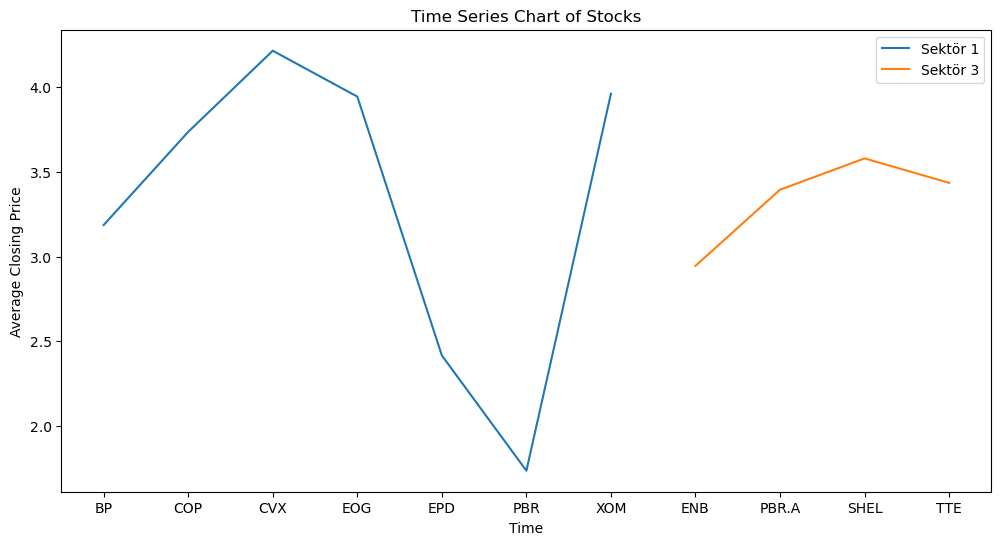

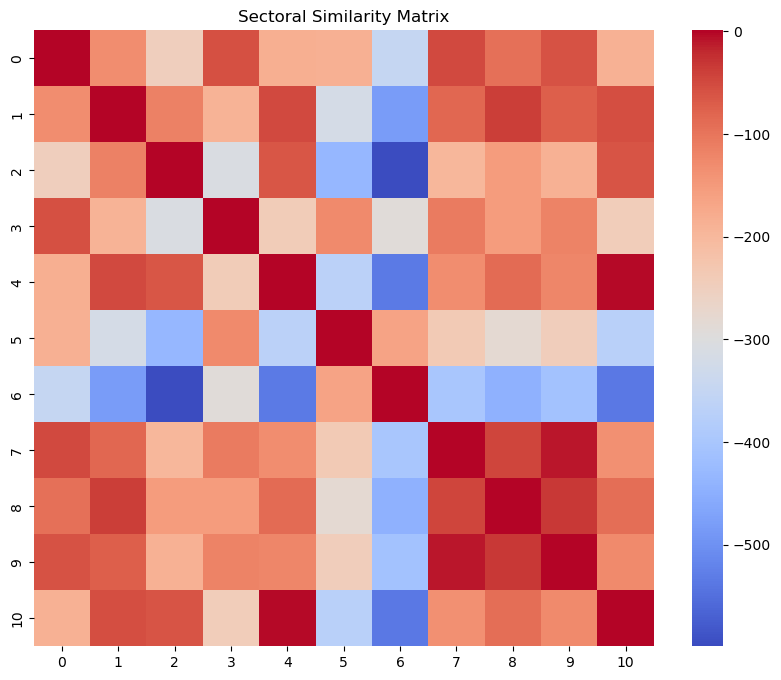

In [58]:
plt.figure(figsize=(12, 6))
for sector in energy_df_features['Predicted_Sector'].unique():
    sector_stocks = energy_df_features[energy_df_features['Predicted_Sector'] == sector]
    plt.plot(sector_stocks.index, sector_stocks['Close_Price__mean'], label=f"Sektör {sector}")

plt.xlabel("Time")
plt.ylabel("Average Closing Price")
plt.title("Time Series Chart of Stocks")
plt.legend()
plt.show()

similarity_matrix = 1 - squareform(pdist(energy_df_features[feature_cols], metric='euclidean'))
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=False, cmap="coolwarm")
plt.title("Sectoral Similarity Matrix")
plt.show()


<Axes: >

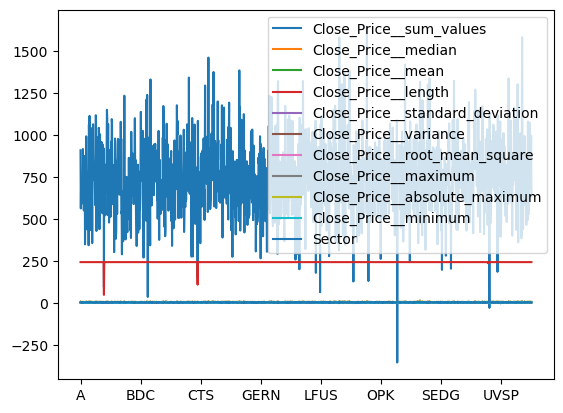

In [61]:
df_features.plot()

### Genel Sonuçlar ve Çıkarımlar:  

Yapılan analizler, hisse senetlerinin **zaman serisi davranışlarını** inceleyerek hangi sektörlere daha yakın olduğunu belirlenmesine olanak sağlar.  

**Zaman Serisi Analizi:**  
Hisse senetlerinin kapanış fiyatlarını zaman içinde karşılaştırarak, sektörler arasındaki benzerlikleri ve farklılıklar ortaya koyuldu. Bu analiz, belirli dönemlerde hangi sektörlerin birlikte hareket ettiğini göstererek yatırımcılar için stratejik bilgiler sundu.  

**Benzerlik Matrisi:**  
Euclidean mesafesi kullanılarak oluşturulan **sektörel benzerlik matrisi**, hisse senetlerinin **hangi sektörle daha fazla ortak noktaya sahip olduğunun** belirlenmesine yardımcı oldu.

**Makine Öğrenmesi Modelleri:**  
Elde edilen özellikleri kullanarak **L1 düzenlemeli lojistik regresyon ve gelişmiş sınıflandırıcılarla** en önemli değişkenler seçildi ve hisse senetleri sektörlerine göre ayrıldı. Özellikle **RandomForest, XGBoost ve CatBoost gibi modeller**, sektör tahmininde başarılı sonuçlar verdi.  


### TEŞEKKÜRLER! - Pelinsu Kaleli